In [ ]:
pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Install the scikit-cuda package containing the FFT facilities.

In [ ]:
pip install scikit-cuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

In [ ]:
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import pycuda.cumath
from pycuda.compiler import SourceModule

from skcuda import fft

/usr/local/lib/python3.7/dist-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
###################
# iDivUp FUNCTION #
###################
def iDivUp(a, b):
    # Round a / b to nearest higher integer value
    a = np.int32(a)
    b = np.int32(b)
    return (a / b + 1) if (a % b != 0) else (a / b)

Without fftshift.

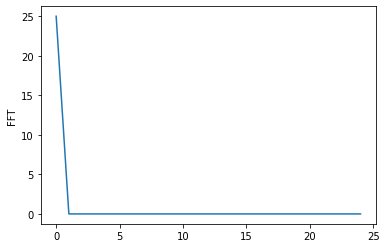

In [ ]:
M = 25

h_x = np.ones((M, 1), dtype = np.complex64)
d_x = gpuarray.to_gpu(h_x)

d_y = gpuarray.empty_like(d_x, dtype = np.complex64)

plan = fft.Plan(d_x.shape, np.complex64, np.complex64)
fft.fft(d_x, d_y, plan)
  
h_y = d_y.get()

plt.plot(np.abs(h_y))
plt.ylabel('FFT')
plt.show()

With fftshift.

In [ ]:
mod = SourceModule("""

#define PI_f      3.1415927410125732421875

/***************/
/* FFTSHIFT 1D */
/***************/
__global__ void ffthisft_1d_complex64_even(float2 *u_d, int N)
{
  int i = blockDim.x * blockIdx.x + threadIdx.x;
  if(i < N)
  {
    //float a = pow(-1.0f, i&1);
    float a = (float)(1-2*((int)i%2));
    u_d[i].x *= a;
    u_d[i].y *= a;
  }
}


__global__ void ffthisft_1d_complex64_odd(float2 *u_d, int N)
{
  int i = blockDim.x * blockIdx.x + threadIdx.x;
  if(i < N)
  {
    float2 a, out;
    a.x           = cosf(PI_f * (N - 1) * i / N);
    a.y           = sinf(PI_f * (N - 1) * i / N);
    out.x         = u_d[i].x * a.x - u_d[i].y * a.y;
    out.y         = u_d[i].y * a.x + u_d[i].x * a.y;
    u_d[i]        = out;
  }
}

""")

ffthisft_1d_complex64_even 		= mod.get_function("ffthisft_1d_complex64_even")
ffthisft_1d_complex64_odd 		= mod.get_function("ffthisft_1d_complex64_odd")

def fftshift_1d_complex64(d_x, M, blockDim, gridDim):
  if (M % 2) == 0:
    ffthisft_1d_complex64_even(d_x, np.int32(M), block = blockDim, grid = gridDim)
  else:
    ffthisft_1d_complex64_odd(d_x, np.int32(M), block = blockDim, grid = gridDim)

  return d_x

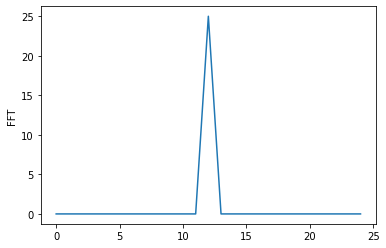

In [ ]:
BLOCKSIZE = 256

blockDim  = (BLOCKSIZE, 1, 1)
gridDim   = (int(iDivUp(M, BLOCKSIZE)), 1, 1)

fftshift_1d_complex64(d_x, M, blockDim, gridDim)
fft.fft(d_x, d_y, plan)
  
h_y = d_y.get()

plt.plot(np.abs(h_y))
plt.ylabel('FFT')
plt.show()

In [ ]:
print(h_y)

[[-5.1259995e-06+1.7434359e-06j]
 [ 1.7946165e-06+6.2885533e-06j]
 [-4.7683716e-06+3.9832871e-06j]
 [-6.2769896e-06-9.4767631e-07j]
 [-1.2240798e-06-4.0880195e-06j]
 [-4.7643916e-06+4.4593262e-06j]
 [-6.4479700e-06-7.2281346e-06j]
 [-6.1107767e-07-3.8086391e-06j]
 [ 1.9248678e-06-1.0793643e-05j]
 [ 6.6619255e-06-2.5869356e-06j]
 [ 8.1351554e-06-1.8872665e-06j]
 [ 1.3794814e-05-9.9794534e-07j]
 [ 2.5000000e+01+2.9717343e-05j]
 [-1.3768773e-05-1.0489161e-06j]
 [-8.4384128e-06-1.6332210e-06j]
 [-6.6161138e-06-2.4099131e-06j]
 [-1.3285621e-06-1.0268821e-05j]
 [ 9.5367432e-07-3.3249080e-06j]
 [ 6.8730892e-06-6.9356151e-06j]
 [ 4.6432233e-06+4.3820269e-06j]
 [ 1.2187919e-06-3.9917450e-06j]
 [ 6.0837856e-06-7.8203925e-07j]
 [ 3.8191556e-06+4.0781879e-06j]
 [-1.8652157e-06+6.4504634e-06j]
 [ 4.9853638e-06+1.6308120e-06j]]
